# Тестирование классификаторов

In [ ]:
import sys
import os
current_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from utils.metrics import cross_validation, create_model
from utils.preparation import min_max_scale 

## Подготовка данных

In [4]:
data=pd.read_csv('../data/breast-cancer.csv', sep=',')

In [5]:
data=data.drop(['id'], axis=1)
data[(data[['diagnosis']]=='M')]=1
data[(data[['diagnosis']]=='B')]=-1
y=data[['diagnosis']].to_numpy().reshape(-1).astype(np.int8)
data=data.drop(['diagnosis'], axis=1)
data=data.drop(['radius_mean', 'area_mean', 'radius_mean', 'radius_worst', 'area_worst', 'perimeter_worst'], axis=1)
data=data.drop(['concavity_mean', 'concave points_mean', 'texture_worst'], axis=1)
data=data.drop(['area_se', 'perimeter_se', 'compactness_worst','concave points_worst'], axis=1)
data=data.drop(['smoothness_worst','concavity_worst'], axis=1)
X=data.to_numpy()

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=24)

In [8]:
X_st=min_max_scale(X)
X_train_st=min_max_scale(X_train)
X_test_st=min_max_scale(X_test)

## Наивный байесовский классификатор

In [6]:
from BayesClassifier import GaussianNBC
from sklearn.naive_bayes import GaussianNB

In [7]:
NBC=GaussianNBC()
NBC_etalon=GaussianNB()

In [8]:
start = time.time()
NBC.fit(X_train,y_train)
y_pred=NBC.predict(X_test)
end = time.time()
print("Время обучения и предсказания реализованного алгоритма:",
      round((end-start) * 10**3,3), "ms")
start = time.time()
NBC_etalon.fit(X_train,y_train)
y_pred=NBC_etalon.predict(X_test)
end = time.time()
print("Время обучения и предсказания эталонного алгоритма",
      round((end-start) * 10**3,3), "ms")

Время обучения и предсказания реализованного алгоритма: 0.412 ms
Время обучения и предсказания эталонного алгоритма 1.045 ms


In [11]:
print("Точность написанного вручную алгоритма с использованием кросс-валидации:", round(cross_validation(GaussianNBC,X,y,5),4))
print("Точность эталонной реализации алгоритма с использованием кросс-валидации:", round(cross_validation(GaussianNB,X,y,5),4))

Точность написанного вручную алгоритма с использованием кросс-валидации: 0.9033
Точность эталонной реализации алгоритма с использованием кросс-валидации: 0.9033


## Линейный классификатор

In [10]:
from LinClassifier import LinearClassifier
from sklearn.linear_model import SGDClassifier

Рассмотрим разные варианты обучения модели и сравним лучшую по скорости и точности с эталонной

In [11]:
print('Точность классификации при использовании предъявления по модулю отступа\
 и инициализации весов через мультистарт:',round(cross_validation(LinearClassifier,X_st,y,5, fit_params={'margin_present':True,
                                                               'init_weights':'multistart','lr':0.1,'t':0.1,
                                                                 'eps':0.0001,'inertion':0.8,
                                                                   'lambda_rec':0.95}),4))

Точность классификации при использовании предъявления по модулю отступа и инициализации весов через мультистарт: 0.812


In [12]:
print('Точность классификации при использовании предъявления по модулю отступа\
 и инициализации весов через корреляцию:',round(cross_validation(LinearClassifier,X_st,y,5, fit_params={'margin_present':True, 'init_weights':'correlation',
                                                              'lr':0.1,'t':0.1, 'eps':0.0005,
                                                              'inertion':0.8, 'lambda_rec':0.95}),4))

Точность классификации при использовании предъявления по модулю отступа и инициализации весов через корреляцию: 0.789


In [13]:
print('Точность классификации при случайном предъявлении\
 и инициализации весов через мультистарт:',round(cross_validation(LinearClassifier,X_st,y,5, fit_params={'margin_present':False, 'init_weights':'multistart', 'lr':0.1
                            ,'t':0.001, 'eps':0.0005,'inertion':0.8, 'lambda_rec':0.95}),4))

Точность классификации при случайном предъявлении и инициализации весов через мультистарт: 0.9016


Наибольшая точность была получена при случайном предъявлении весов и инициалихации весов через мультистарт. Сравним её с моделью из sklearn

In [ ]:
print('Точность эталонного классификатора:',round(cross_validation(create_model(
    SGDClassifier,
loss='squared_error', penalty="l2",learning_rate = 'constant',eta0=0.1,alpha=0.05,max_iter=X_train.shape[0],tol=0.0005
),X_st,y,5),4))

Точность эталонного классификатора: 0.877


In [15]:
lc=LinearClassifier()
etalon_lc=SGDClassifier(loss='squared_error', penalty="l2",learning_rate = 'constant',eta0=0.1,alpha=0.05,max_iter=X_train.shape[0],tol=0.0005)
start = time.time()
lc.fit(X_train_st,y_train,margin_present=False, init_weights='multistart', lr=0.1
                            ,t=0.0001, eps=0.0005,inertion=0.8, lambda_rec=0.95)
y_pred=lc.predict(X_test_st)
end = time.time()
print("Время обучения и предсказания реализованного алгоритма:",
      round((end-start) * 10**3,3), "ms")
start = time.time()
etalon_lc.fit(X_train_st,y_train)
y_pred=etalon_lc.predict(X_test_st)
end = time.time()
print("Время обучения и предсказания эталонного алгоритма",
      round((end-start) * 10**3,3), "ms")

Время обучения и предсказания реализованного алгоритма: 33.086 ms
Время обучения и предсказания эталонного алгоритма 1.142 ms


Также эта модель позволяет визуализировать отступы объектов

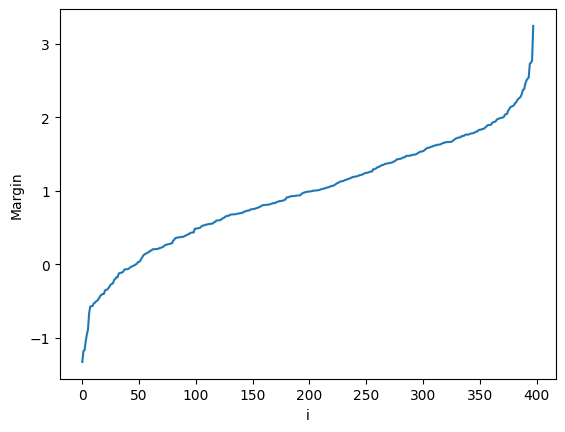

In [16]:
lc.visualise_margins(X_train_st, y_train)

## SVM

In [72]:
from SVM import SVM
from sklearn.svm import SVC

Для каждого ядра посчитаем точность классификации и сравним наилучшую с эталонной реализацией

In [69]:
print('Точность классификации SVM с линейным ядром:',round(cross_validation(SVM,X_st,y,5, fit_params={'solution':'linear','c':2}),4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -134.8382247324358
            Iterations: 58
            Function evaluations: 26454
            Gradient evaluations: 58
Optimization terminated successfully    (Exit mode 0)
            Current function value: -140.98047958148618
            Iterations: 60
            Function evaluations: 27366
            Gradient evaluations: 60
Optimization terminated successfully    (Exit mode 0)
            Current function value: -129.42722435144123
            Iterations: 53
            Function evaluations: 24174
            Gradient evaluations: 53
Optimization terminated successfully    (Exit mode 0)
            Current function value: -137.65520071893144
            Iterations: 46
            Function evaluations: 20980
            Gradient evaluations: 46
Optimization terminated successfully    (Exit mode 0)
            Current function value: -126.7468497615306
            Iterations: 41
         

In [70]:
print('Точность классификации SVM с ядром RBF',round(cross_validation(SVM,X_st,y,5, fit_params={'solution':'rbf','c':3}),4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -190.4510802389607
            Iterations: 52
            Function evaluations: 23716
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.25778752935696
            Iterations: 53
            Function evaluations: 24173
            Gradient evaluations: 53
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.6993564477287
            Iterations: 51
            Function evaluations: 23260
            Gradient evaluations: 51
Optimization terminated successfully    (Exit mode 0)
            Current function value: -197.477330074139
            Iterations: 63
            Function evaluations: 28732
            Gradient evaluations: 63
Optimization terminated successfully    (Exit mode 0)
            Current function value: -179.11044684070635
            Iterations: 52
           

In [71]:
print('Точность классификации SVM с полиномиальным ядром степени 3',round(cross_validation(SVM,X_st,y,5, fit_params={'solution':'poly','c':3,'d':3}),4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -125.18619914523295
            Iterations: 50
            Function evaluations: 22814
            Gradient evaluations: 50
Optimization terminated successfully    (Exit mode 0)
            Current function value: -135.3275029001593
            Iterations: 58
            Function evaluations: 26462
            Gradient evaluations: 58
Optimization terminated successfully    (Exit mode 0)
            Current function value: -119.12068480923074
            Iterations: 51
            Function evaluations: 23270
            Gradient evaluations: 51
Optimization terminated successfully    (Exit mode 0)
            Current function value: -129.71214252456892
            Iterations: 49
            Function evaluations: 22360
            Gradient evaluations: 49
Optimization terminated successfully    (Exit mode 0)
            Current function value: -119.77920490886223
            Iterations: 52
        

Наиболее точным оказался SVM с rbf-ядром

In [ ]:
print('Точность эталонной реализации: ',round(cross_validation(create_model(SVC, kernel='rbf', C=3, gamma=1/(X_train_st.shape[1]*np.std(X_train_st))),X_st,y,5),4))

Точность эталонной реализации:  0.9578


In [87]:
svm=SVM()
etalon_svm=SVC(kernel='rbf', C=3, gamma=1/(X_train_st.shape[1]*np.std(X_train_st)))
start = time.time()
svm.fit(X_train_st,y_train, solution='rbf',c=3)
y_pred=lc.predict(X_test_st)
end = time.time()
print("Время обучения и предсказания реализованного алгоритма:",
      round((end-start) * 10**3,3), "ms")
start = time.time()
etalon_svm.fit(X_train_st,y_train)
y_pred=etalon_svm.predict(X_test_st)
end = time.time()
print("Время обучения и предсказания эталонного алгоритма",
      round((end-start) * 10**3,3), "ms")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -180.26108253296323
            Iterations: 55
            Function evaluations: 21949
            Gradient evaluations: 55
Время обучения и предсказания реализованного алгоритма: 312143.834 ms
Время обучения и предсказания эталонного алгоритма 2.875 ms


## KNN

In [19]:
from knn import KNN
from sklearn.neighbors import KNeighborsClassifier

In [20]:
knn=KNN()

Построим график эмпирического риска, где с помощью метода leave_one_out высчитывается точность классификации и выбирается оптимальный k


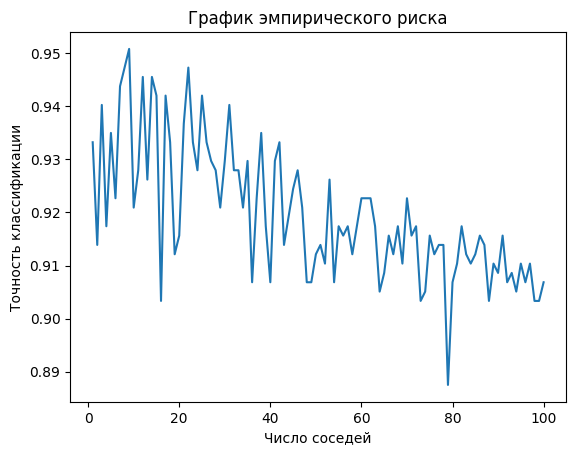

In [21]:
knn.build_graph(X_st,y)

In [22]:
knn=KNN()
etalon_knn=KNeighborsClassifier(n_neighbors=6,weights='distance')
start = time.time()
knn.fit_predict(X_train_st,y_train,X_test_st,k=6)
end = time.time()
print("Время обучения и предсказания реализованного алгоритма:",
      round((end-start) * 10**3,3), "ms")
start = time.time()
etalon_knn.fit(X_train_st,y_train)
y_pred=etalon_knn.predict(X_test_st)
end = time.time()
print("Время обучения и предсказания эталонного алгоритма",
      round((end-start) * 10**3,3), "ms")

Время обучения и предсказания реализованного алгоритма: 7.49 ms
Время обучения и предсказания эталонного алгоритма 188.659 ms


In [23]:
print('Точность классификации реализованной модели',round(cross_validation(KNN,X_st,y,5, fit_params={'k':6}, fit_predict=True),4))

Точность классификации реализованной модели 0.9438


In [ ]:
print('Точность эталонной реализации: ',round(cross_validation(create_model(KNeighborsClassifier, n_neighbors=6,weights='distance'),X_st,y,5),4))

Точность эталонной реализации:  0.9472
